![delensalot logo](./../../res/dlensalot2.PNG)

# Interactive minimal working example - data access - full sky
In this notebook, you access your own data; maps, alms, or cls. Depending on what you provide, `delensalot` will either use them 'as is', generate noise on top of it, lens the data, or synthesize realisations from the provided power spectra.

This all comes with a very hand interface and only a couple of parameter, which we will explore in the following.

The `delensalot` model-object responisible for handling the data is `DLENSALOT_Simulation` and we will make heavy use of it.

In [2]:
from IPython.display import clear_output
from datetime import datetime
import os
from os.path import join as opj

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from lenspyx.remapping.utils_geom import Geom
from lenspyx.lensing import get_geom 

import delensalot
from delensalot import utils
from delensalot.run import run
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

from delensalot.utility.utils_hp import gauss_beam, Alm, almxfl, alm_copy
from delensalot.utility.plot_helper import bandpass_alms, movavg
from delensalot.config.visitor import transform, transform3d
from delensalot.config.transformer.lerepi2dlensalot import l2delensalotjob_Transformer, l2T_Transformer
from delensalot.config.metamodel.dlensalot_mm import DLENSALOT_Model, DLENSALOT_Analysis, DLENSALOT_Simulation, DLENSALOT_Itrec

from delensalot.core.iterator.iteration_handler import iterator_transformer
from delensalot.core.opfilt.opfilt_handler import QE_transformer, MAP_transformer

paths = {'unl': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/unl/'), 'sky': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/sky/'), 'obs': opj(os.environ["SCRATCH"], 'simulation/mwe_dataaccess/obs/')}

beam = 1.
nlev = {'T': np.sqrt(2), 'P': np.sqrt(4)}
nside = 2048
lmax = 2500
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
# geominfo = ('tgl',{'lmax': lmax, 'smax': 3})
# geominfo = ('thingauss',{'lmax': lmax, 'smax': 3})
geominfo = ('healpix',{'nside': nside})
geom_lib = get_geom(geominfo)
print(Geom.get_supported_geometries())
CAMB_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')
CAMB = utils.camb_clfile(CAMB_fn)

 thingauss healpix cc f1 gl tgl


### Prerequisite: generate example data
Before we can access data, we will need some. You can use `sim_lib` to generate them.

## Check mapspace

Per default, lensing is done onto a thingauss geometry, and maps are returned as healpix geometry. The maps are physically correct, but naively turning them into a power spectrum will give a wrong result at high ell, because of the healpix geometry. `hp.map2alm()` solves this by iteratively finding alms such that the inverse gives similar maps again.

In [2]:
synunl = Xunl(lmax=lmax, geominfo=geominfo)
Tunl = synunl.get_sim_unl(0, spin=0, space='map', field='temperature')
QUunl = synunl.get_sim_unl(0, spin=2, space='map', field='polarization')
EBunl = synunl.get_sim_unl(0, spin=0, space='map', field='polarization')

phi = synunl.get_sim_phi(0, space='map')
# phi *= 10
# synunl.cacher.cache('phi_space{}_{}'.format('map', 0), phi)

synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)
Tsky = synsky.get_sim_sky(0, spin=0, space='map', field='temperature')
QUsky = synsky.get_sim_sky(0, spin=2, space='map', field='polarization')
EBsky = synsky.get_sim_sky(0, spin=0, space='map', field='polarization')

synobs = Xobs(lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev=nlev, geominfo=geominfo)
Tobs = synobs.get_sim_obs(0, spin=0, space='map', field='temperature')
QUobs = synobs.get_sim_obs(0, spin=2, space='map', field='polarization')
EBobs = synobs.get_sim_obs(0, spin=0, space='map', field='polarization')

Tnoise = synobs.get_sim_noise(0, spin=0, space='map', field='temperature')
EBnoise = synobs.get_sim_noise(0, spin=0, space='map', field='polarization')
QUnoise = synobs.get_sim_noise(0, spin=2, space='map', field='polarization')

space = 'map'

INFO:: 06-20 14:27:49:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacemap_spin0_fieldtemperature_0"
INFO:: 06-20 14:27:49:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 06-20 14:27:49:: delensalot.sims.sims_lib.get_sim_sky - .., generating.
INFO:: 06-20 14:27:56:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacemap_spin2_fieldpolarization_0"
INFO:: 06-20 14:27:56:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 06-20 14:27:56:: delensalot.sims.sims_lib.get_sim_sky - .., generating.
INFO:: 06-20 14:28:08:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacemap_spin0_fieldpolarization_0"
INFO:: 06-20 14:28:08:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 06-20 14:28:08:: delensalot.sims.sims_lib.get_sim_sky - .., generating.
INFO:: 06-20 14:28:19:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacemap_spin0_fieldtemperature_0"
INFO:: 06-20 14:28:19:: delensalot.sims.sims_lib.get_sim_ob

Text(0, 0.5, '$D_\\ell$')

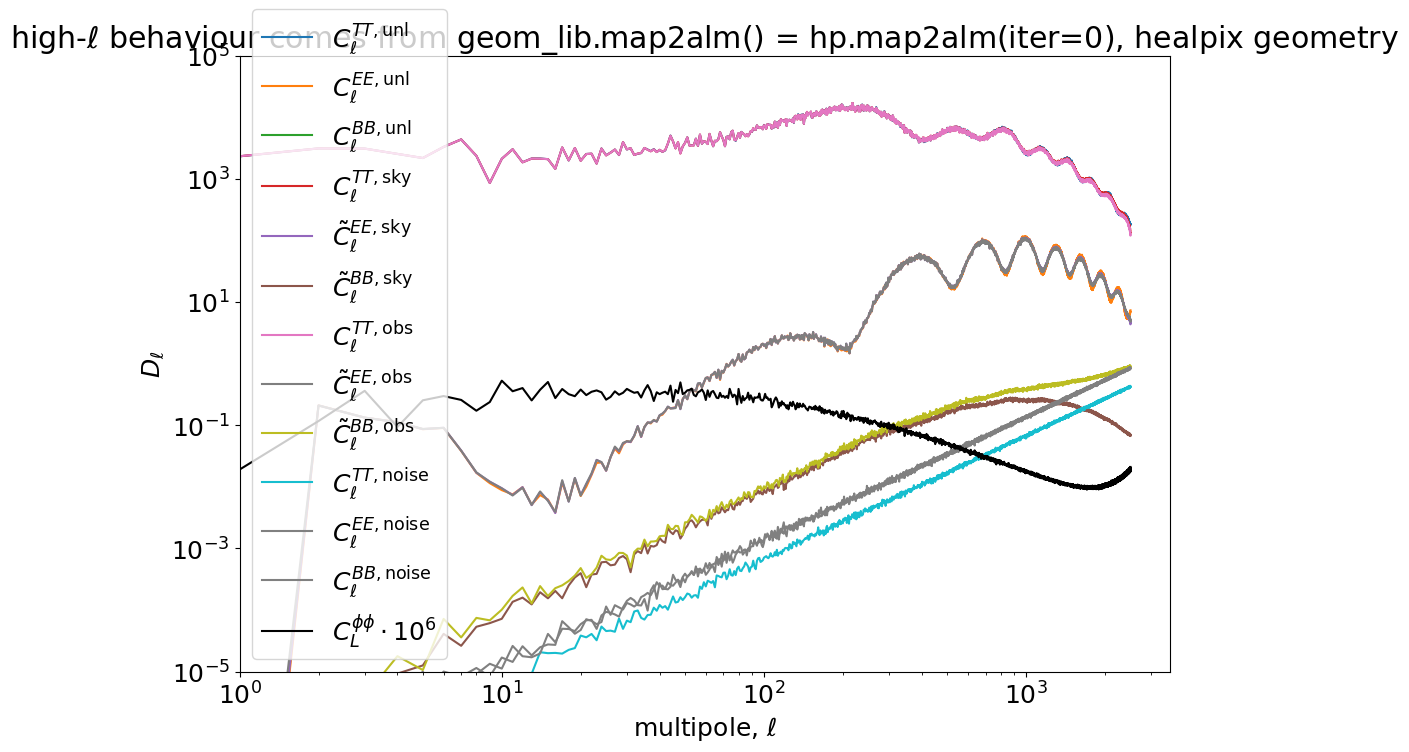

In [3]:
fig = plt.figure(figsize=(12,8))
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,np.min([3*nside,lmax])+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.title('high-$\ell$ behaviour comes from geom_lib.map2alm() = hp.map2alm(iter=0), healpix geometry')
plt.plot(scale_factor_l * hp.alm2cl(geom_lib.map2alm(np.copy(Tunl), lmax=lmax, mmax=lmax, nthreads=4)), label=r'$C_\ell^{TT, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(geom_lib.map2alm(np.copy(EBunl[0]), lmax=lmax, mmax=lmax, nthreads=4)), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBunl[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tsky), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{sky}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBsky[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBsky[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tobs), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{obs}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBobs[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBobs[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(Tnoise), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{TT, \rm{noise}}$')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBnoise[0]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{EE, \rm{noise}}$', color='grey')
plt.plot(scale_factor_l * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(EBnoise[1]), lmax=lmax, mmax=lmax, nthreads=4))), label=r'$C_\ell^{BB, \rm{noise}}$', color='grey')
plt.plot(scale_factor_L * np.copy(hp.alm2cl(geom_lib.map2alm(np.copy(phi), lmax=lmax, mmax=lmax, nthreads=4))*10**6), color='black', label=r'$C_L^{\phi\phi} \cdot 10^6$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-5,1e5)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

Text(0, 0.5, '$D_\\ell$')

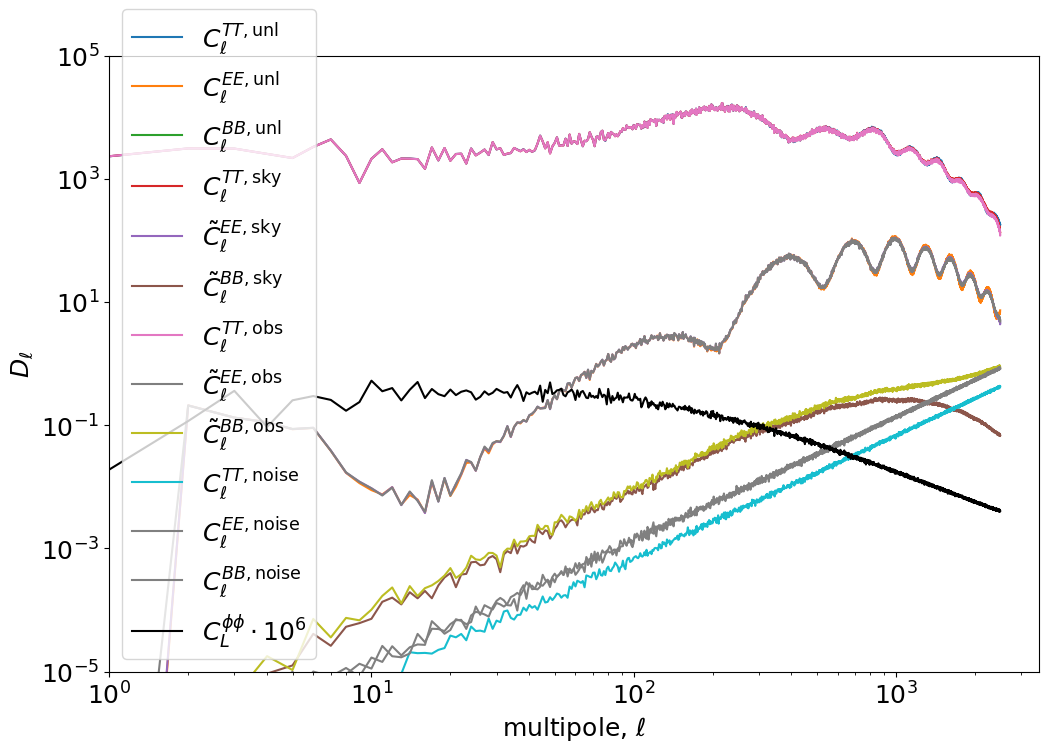

In [4]:
fig = plt.figure(figsize=(12,8))
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,np.min([3*nside,lmax])+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(Tunl, lmax=lmax, mmax=lmax)), label=r'$C_\ell^{TT, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBunl[0], lmax=lmax, mmax=lmax)), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBunl[1], lmax=lmax, mmax=lmax)), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(Tsky, lmax=lmax, mmax=lmax)), label=r'$C_\ell^{TT, \rm{sky}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBsky[0], lmax=lmax, mmax=lmax)), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBsky[1], lmax=lmax, mmax=lmax)), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(Tobs, lmax=lmax, mmax=lmax)), label=r'$C_\ell^{TT, \rm{obs}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBobs[0], lmax=lmax, mmax=lmax)), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBobs[1], lmax=lmax, mmax=lmax)), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(Tnoise, lmax=lmax, mmax=lmax)), label=r'$C_\ell^{TT, \rm{noise}}$')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBnoise[0], lmax=lmax, mmax=lmax)), label=r'$C_\ell^{EE, \rm{noise}}$', color='grey')
plt.plot(scale_factor_l * hp.alm2cl(hp.map2alm(EBnoise[1], lmax=lmax, mmax=lmax)), label=r'$C_\ell^{BB, \rm{noise}}$', color='grey')

plt.plot(scale_factor_L * hp.alm2cl(hp.map2alm(phi, lmax=lmax, mmax=lmax))*10**6, color='black', label=r'$C_L^{\phi\phi} \cdot 10^6$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-5,1e5)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Check almspace
If we request the data in alm space, we can skip the map2alm and get correct power spectra (and correct maps via alm2map, if needed)

In [5]:
from delensalot.sims.sims_lib import Xunl, Xsky, Xobs

synunl = Xunl(lmax=lmax, geominfo=geominfo)
Tunl = synunl.get_sim_unl(0, spin=0, space='alm', field='temperature')
EBunl = synunl.get_sim_unl(0, spin=0, space='alm', field='polarization')
phi = synunl.get_sim_phi(0, space='alm')
# phi = EBunl[0]*1e-7
# synunl.cacher.cache('phi_space{}_{}'.format('alm', 0), phi)

synsky = Xsky(lmax=lmax, unl_lib=synunl, geominfo=geominfo)
Tsky = synsky.get_sim_sky(0, spin=0, space='alm', field='temperature')
EBsky = synsky.get_sim_sky(0, spin=0, space='alm', field='polarization')

synobs = Xobs(lmax=lmax, len_lib=synsky, transfunction=transfunction, nlev=nlev, geominfo=geominfo, libdir_suffix='')
Tobs = synobs.get_sim_obs(0, spin=0, space='alm', field='temperature')
EBobs = synobs.get_sim_obs(0, spin=0, space='alm', field='polarization')
Tnoise = synobs.get_sim_noise(0, spin=0, space='alm', field='temperature')
EBnoise = synobs.get_sim_noise(0, spin=0, space='alm', field='polarization')

space = 'alm'

INFO:: 08-06 22:43:15:: delensalot.sims.sims_lib.__init__ - phi_fn is /mnt/d/Uni/ext/git/delensalot/delensalot/data/cls/FFP10_wdipole_lenspotentialCls.dat
INFO:: 08-06 22:43:16:: delensalot.sims.sims_lib.__init__ - phi_fn is /mnt/d/Uni/ext/git/delensalot/delensalot/data/cls/FFP10_wdipole_lenspotentialCls.dat


INFO:: 08-06 22:43:17:: delensalot.sims.sims_lib.get_sim_phi - generating phi from cl
INFO:: 08-06 22:43:17:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldtemperature_0"
INFO:: 08-06 22:43:17:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 08-06 22:43:17:: delensalot.sims.sims_lib.get_sim_sky - .., generating.
INFO:: 08-06 22:43:20:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_spin0_fieldpolarization_0"
INFO:: 08-06 22:43:20:: delensalot.sims.sims_lib.get_sim_sky - ..nothing cached..
INFO:: 08-06 22:43:20:: delensalot.sims.sims_lib.get_sim_sky - .., generating.
INFO:: 08-06 22:43:23:: delensalot.sims.sims_lib.get_sim_obs - requesting "obs_spacealm_spin0_fieldtemperature_0"
INFO:: 08-06 22:43:23:: delensalot.sims.sims_lib.get_sim_obs - ..nothing cached..
INFO:: 08-06 22:43:23:: delensalot.sims.sims_lib.get_sim_obs - .., generating.
INFO:: 08-06 22:43:23:: delensalot.sims.sims_lib.get_sim_sky - requesting "sky_spacealm_

Text(0, 0.5, '$D_\\ell$')

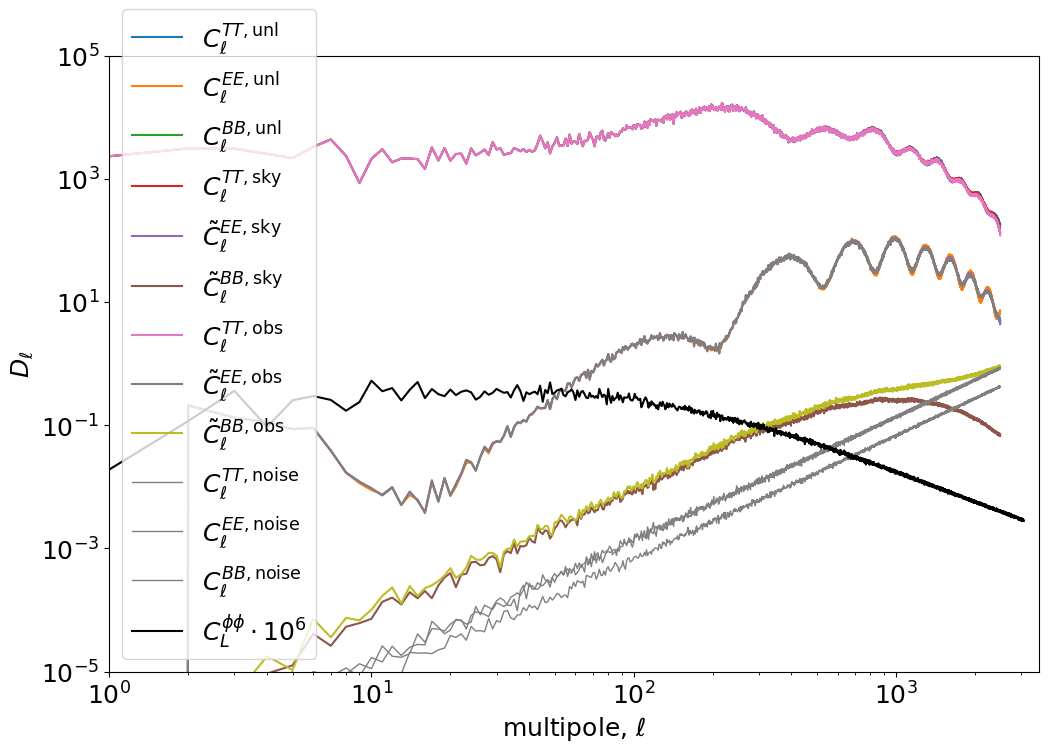

In [33]:
fig = plt.figure(figsize=(12,8))
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,synunl.phi_lmax+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.alm2cl(Tunl, lmax=lmax), label=r'$C_\ell^{TT, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBunl[0], lmax=lmax), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBunl[1], lmax=lmax), label=r'$C_\ell^{BB, \rm{unl}}$')

plt.plot(scale_factor_l * hp.alm2cl(Tsky, lmax=lmax), label=r'$C_\ell^{TT, \rm{sky}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBsky[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBsky[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{sky}}$')

plt.plot(scale_factor_l * hp.alm2cl(Tobs, lmax=lmax), label=r'$C_\ell^{TT, \rm{obs}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBobs[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.alm2cl(EBobs[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.plot(scale_factor_l * hp.alm2cl(Tnoise, lmax=lmax), label=r'$C_\ell^{TT, \rm{noise}}$', color='grey', lw=1)
plt.plot(scale_factor_l * hp.alm2cl(EBnoise[0], lmax=lmax), label=r'$C_\ell^{EE, \rm{noise}}$', color='grey', lw=1)
plt.plot(scale_factor_l * hp.alm2cl(EBnoise[1], lmax=lmax), label=r'$C_\ell^{BB, \rm{noise}}$', color='grey', lw=1)

plt.plot(scale_factor_L * hp.alm2cl(phi)*10**6, color='black', label=r'$C_L^{\phi\phi} \cdot 10^6$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-5,1e5)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

Text(0, 0.5, '$D_\\ell$')

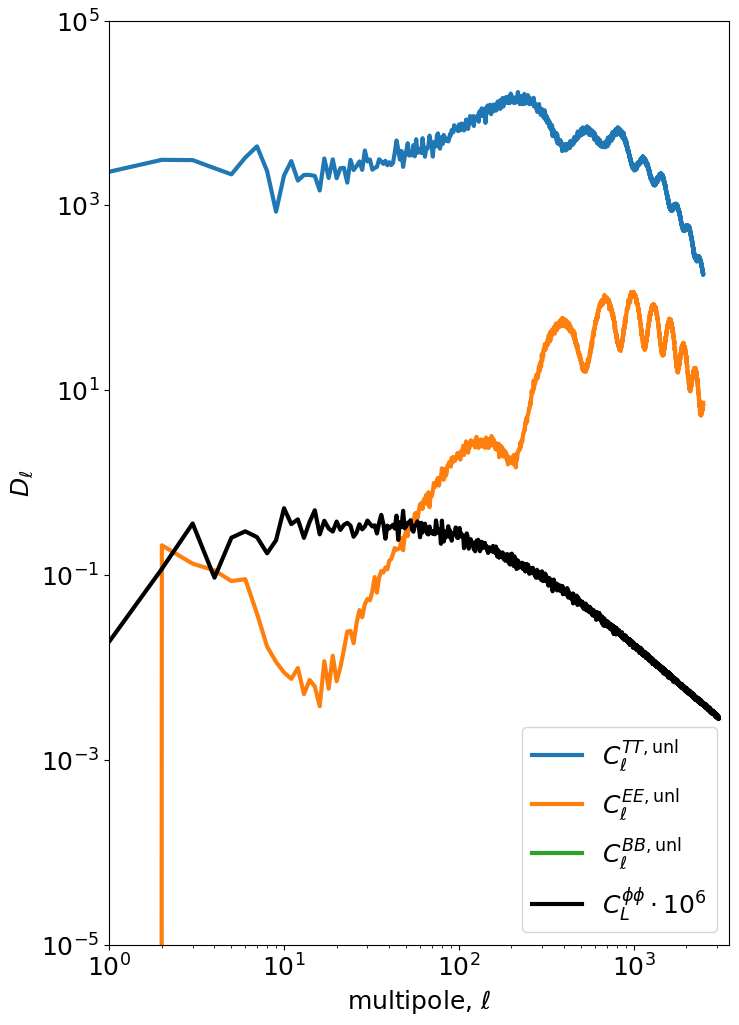

In [4]:
fig = plt.figure(figsize=(8,12))
ll = np.arange(0,lmax+1,1)
LL = np.arange(0,synunl.phi_lmax+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.alm2cl(Tunl, lmax=lmax), label=r'$C_\ell^{TT, \rm{unl}}$', lw=3)
plt.plot(scale_factor_l * hp.alm2cl(EBunl[0], lmax=lmax), label=r'$C_\ell^{EE, \rm{unl}}$', lw=3)
plt.plot(scale_factor_l * hp.alm2cl(EBunl[1], lmax=lmax), label=r'$C_\ell^{BB, \rm{unl}}$', lw=3)

plt.plot(scale_factor_L * hp.alm2cl(phi)*10**6, color='black', label=r'$C_L^{\phi\phi} \cdot 10^6$', lw=3)

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-5,1e5)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

### Other checks

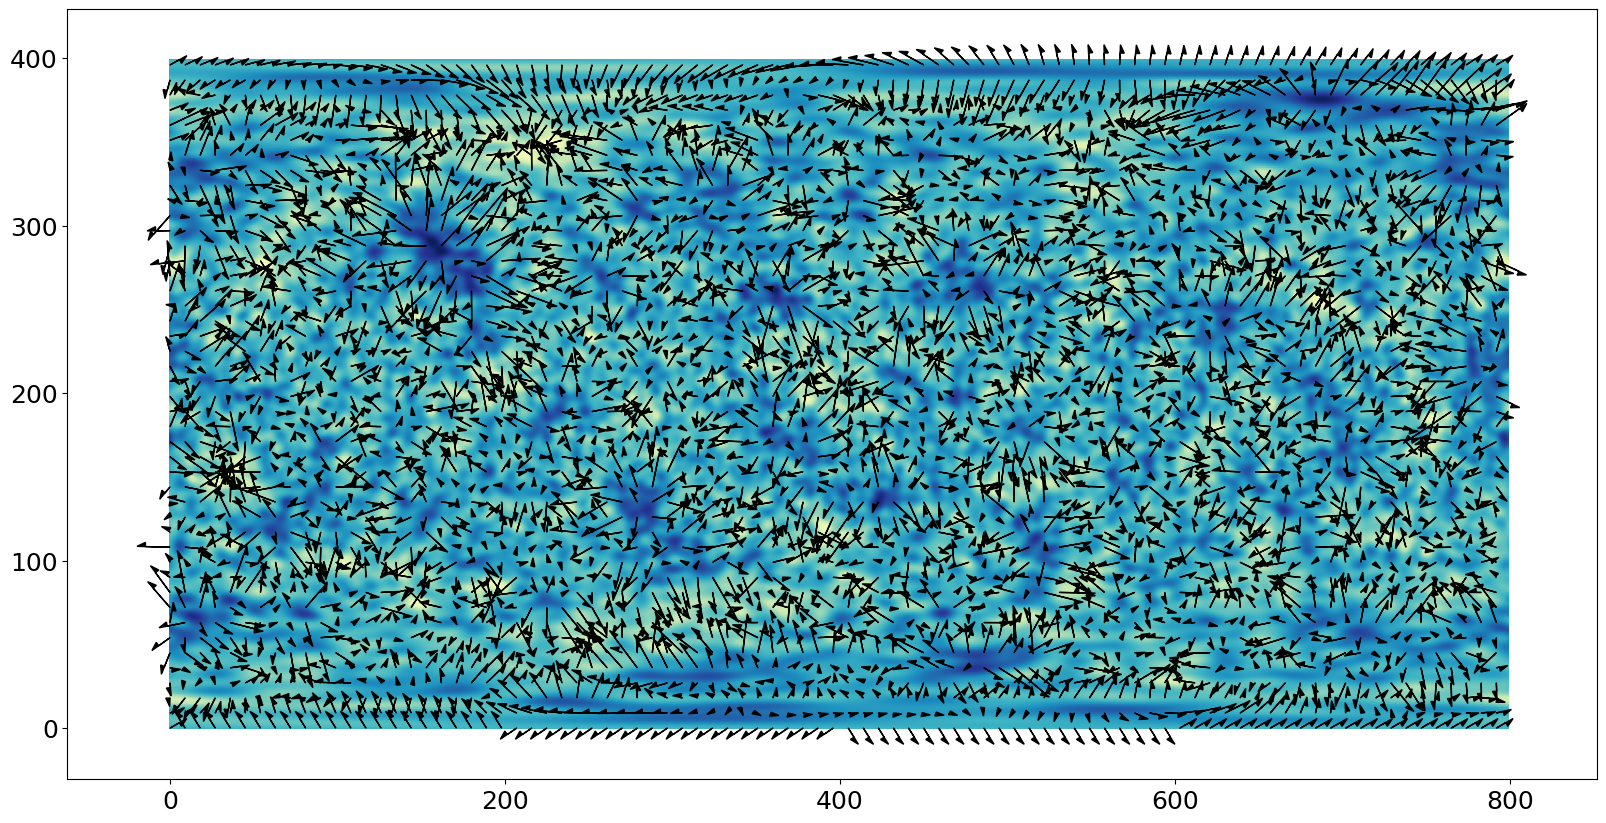

In [24]:
# lmax_ = 30
# phi_ = alm_copy(phi, None, lmax_, lmax_)
phi_ = bandpass_alms(phi, 5, 100)
gclm = np.atleast_2d(phi_)
LL_ = np.arange(0,hp.Alm.getlmax(phi_.shape[0])+1,1)
derivs = geom_lib.synthesis_deriv1(np.copy(gclm), lmax=hp.Alm.getlmax(phi_.shape[0]), mmax=hp.Alm.getlmax(phi_.shape[0]), nthreads=4)
deriv1_cart = hp.cartview(derivs[0], return_projected_map=True)
deriv2_cart = hp.cartview(derivs[1], return_projected_map=True)
plt.show()
clear_output(wait=True)
phi_cart = hp.cartview(hp.alm2map(hp.almxfl(phi_, np.sqrt(LL_*(LL_+1))), nside=geominfo[1]['nside']), return_projected_map=True)
plt.show()
clear_output(wait=True)

def draw_arrow(plt, arr_start, arr_end):
       dx = arr_end[0] - arr_start[0]
       dy = arr_end[1] - arr_start[1]
       plt.arrow(arr_start[0], arr_start[1], dx, dy, head_width=5, head_length=5, length_includes_head=True, color='black', shape='left')

plt.figure(figsize = (20,10))
plt.imshow(phi_cart, origin='lower', cmap='YlGnBu')
for x in np.arange(0, 800, 9):
    for y in np.arange(0, 400, 9):
        draw_arrow(plt, [x,y], [x+2e4*deriv2_cart[y,x],y+2e4*deriv1_cart[y,x]])


### lenspyx lensing

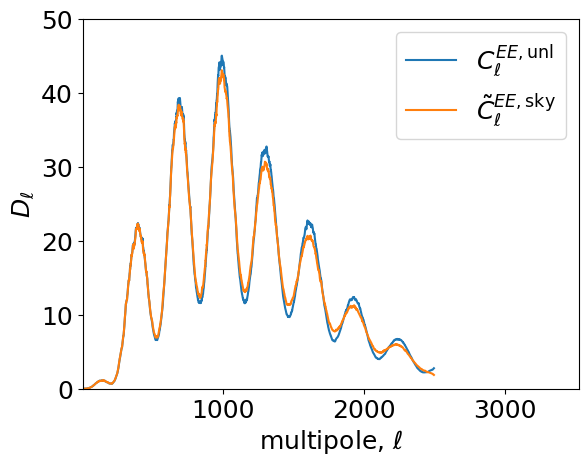

/tmp/ipykernel_1872/546927959.py:19: RuntimeWarning: invalid value encountered in divide
  plt.plot(movavg((hp.alm2cl(EBsky[0], lmax=lmax)-hp.alm2cl(EBunl[0], lmax=lmax))/hp.alm2cl(EBunl[0], lmax=lmax), 8))


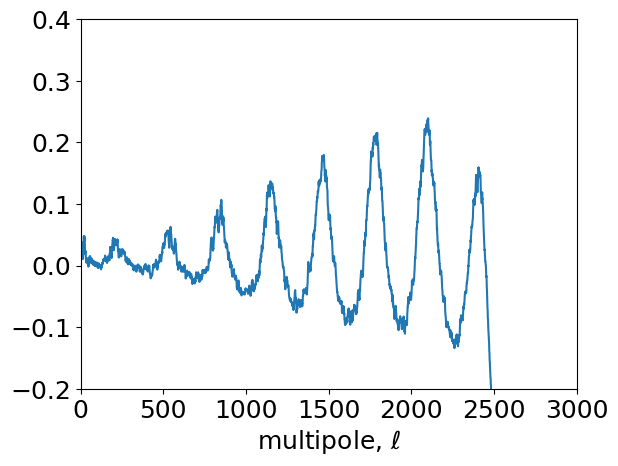

In [25]:
from delensalot.utility.plot_helper import movavg

ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(movavg(scale_factor_l * hp.alm2cl(EBunl[0], lmax=lmax), 8), label=r'$C_\ell^{EE, \rm{unl}}$')
plt.plot(movavg(scale_factor_l * hp.alm2cl(EBsky[0], lmax=lmax) , 8), label=r'$\tilde{C}_\ell^{EE, \rm{sky}}$')

plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(0,0.5e2)

# plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

plt.show()

plt.plot(movavg((hp.alm2cl(EBsky[0], lmax=lmax)-hp.alm2cl(EBunl[0], lmax=lmax))/hp.alm2cl(EBunl[0], lmax=lmax), 8))
plt.ylim(-0.2,0.4)
plt.xlim(0, 3000)
plt.xlabel(r'multipole, $\ell$')

plt.show()

## Store

Once you are happy with the data, store them as follows:
 * for each flavour (unl, sky, obs), make a directory
 * for each component (noise, cmb, phi), store the map and alms in that directory

In [34]:
files = {
    0: {
        'unl': [Tunl, *EBunl], 'sky': [Tsky, *EBsky], 'obs': [Tobs, *EBobs]},
    2: {
        'sky': [Tsky, *QUsky], 'obs': [Tobs, *QUobs]
    }}

for flavour in ['unl', 'sky', 'obs']:
    if not os.path.exists(paths[flavour]):
        os.makedirs(paths[flavour])

for simidx in [0]:
    for flavour in ['unl', 'sky', 'obs']:
        for spin in [2]:
            if space == 'map':
                if flavour != 'unl':
                    fnT = opj(paths[flavour], 'T{}{}_{:05d}.npy'.format(space, flavour, simidx))
                    fnQ = opj(paths[flavour], 'Q{}{}_{:05d}.npy'.format(space, flavour, simidx))
                    fnU = opj(paths[flavour], 'U{}{}_{:05d}.npy'.format(space, flavour, simidx))
                    np.save(fnT, files[spin][flavour][0])
                    np.save(fnQ, files[spin][flavour][1])
                    np.save(fnU, files[spin][flavour][2])

                if flavour == 'sky':
                    fnT = opj(paths[flavour], 'T{}noise_{:05d}.npy'.format(space, simidx))
                    fnQ = opj(paths[flavour], 'Q{}noise_{:05d}.npy'.format(space, simidx))
                    fnU = opj(paths[flavour], 'U{}noise_{:05d}.npy'.format(space, simidx))
                    np.save(fnT, Tnoise[0])
                    np.save(fnQ, QUnoise[0])
                    np.save(fnU, QUnoise[1])
        for spin in [0]:
            fnT = opj(paths[flavour], 'T{}{}_{:05d}.npy'.format(space, flavour, simidx))
            fnE = opj(paths[flavour], 'E{}{}_{:05d}.npy'.format(space, flavour, simidx))
            fnB = opj(paths[flavour], 'B{}{}_{:05d}.npy'.format(space, flavour, simidx))
            np.save(fnT, files[spin][flavour][0])
            np.save(fnE, files[spin][flavour][1])
            np.save(fnB, files[spin][flavour][2])
            if flavour == 'sky':
                fnT = opj(paths[flavour], 'T{}noise_{:05d}.npy'.format(space, simidx))
                fnE = opj(paths[flavour], 'E{}noise_{:05d}.npy'.format(space, simidx))
                fnB = opj(paths[flavour], 'B{}noise_{:05d}.npy'.format(space, simidx))
                np.save(fnT, Tnoise[0])
                np.save(fnE, EBnoise[0])
                np.save(fnB, EBnoise[1])
            if flavour == 'unl':
                fnphi = opj(paths[flavour], 'phi{}_{:05d}.npy'.format(space, simidx))
                np.save(fnphi, phi)

We now have toy data stored at [scratch](./../../reconstruction/simulation/mwe_dataaccess/)

## Case 1: observed or component separated maps (e.g. CMB-S4)
in our first example, imagine you are given observed (or component separated) maps. This is the optimal case for `delensalot`, as nothing needs to be done other than providing the data to it. You may have them as EB or QU maps, and `delensalot` can work with both.

All you have to do is configure a `DLENSALOT_Simulation` with the correct values.

In [5]:
space = 'map'
flavour = 'obs'
lmax = lmax
beam = beam
libdir = paths['obs']
fns = {'Q': 'Q{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'U': 'U{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour)}

dm_spin2 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        libdir = libdir,
        fns = fns,
        spin = 2,
        geominfo = geominfo,
))

fns = {'E': 'E{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'B': 'B{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour)}
dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        libdir = libdir,
        fns = fns,
        spin = 0,
        geominfo = geominfo,
))

INFO:: 06-20 14:53:05:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-20 14:53:05:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-20 14:53:05:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-20 14:53:05:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds


That's it, in principle. This delensalot model will use the simulation as you provided them. Convince yourself by creating a QE lensrec job model `jm`. You can find the provided data via `jm.simulationdata` 

In [6]:
job_id = 'QE_lensrec'
jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())
EBobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

INFO:: 06-20 14:53:09:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:09:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simulation/mwe_dataaccess/obs/ with filenames {'Q': 'Qmapobs_{:05d}.npy', 'U': 'Umapobs_{:05d}.npy'}
INFO:: 06-20 14:53:09:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:09:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simulation/mwe_dataaccess/obs/ with filenames {'Q': 'Qmapobs_{:05d}.npy', 'U': 'Umapobs_{:05d}.npy'}
INFO:: 06-20 14:53:09:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:09:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/

/mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


INFO:: 06-20 14:53:17:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:17:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simulation/mwe_dataaccess/obs/ with filenames {'E': 'Emapobs_{:05d}.npy', 'B': 'Bmapobs_{:05d}.npy'}
INFO:: 06-20 14:53:17:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:17:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/simulation/mwe_dataaccess/obs/ with filenames {'E': 'Emapobs_{:05d}.npy', 'B': 'Bmapobs_{:05d}.npy'}
INFO:: 06-20 14:53:17:: delensalot.core.mpi.inner_function - rank: 0, size: 1, name: x86_64 with 12 cpus
INFO:: 06-20 14:53:17:: delensalot.core.handler.__init__ - Will use obs data stored at /mnt/c/Users/sebas/OneDrive/Desktop/Uni/ext/git/delensalot/reconstruction/

Text(0, 0.5, '$D_\\ell$')

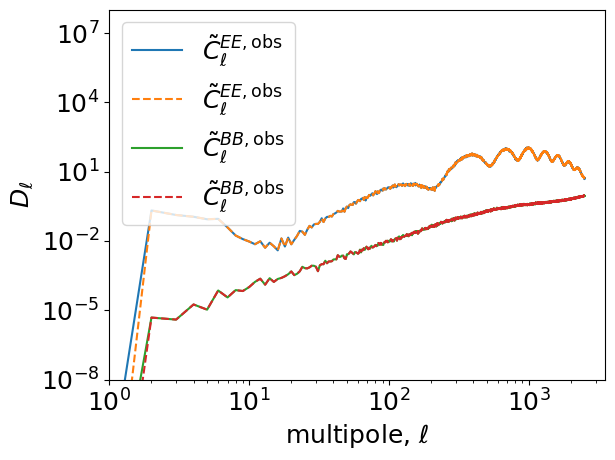

In [7]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/np.sqrt(2*np.pi)
scale_factor_L = (LL*(LL+1))**2/np.sqrt(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')
plt.legend()
plt.xlim(1,lmax+1024)
plt.ylim(1e-8,1e8)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

If you want to delens the data, 
 * simply `run()` one of the models `dm_spin0` or `dm_spin2`, or,
 * take on of the delensalot job models `jm0` or `jm2`, and collect and run their computing jobs 

In [ ]:
mode = 'I prefer the delensalot.run()'
mode = 'I prefer the job model'
if mode == 'I prefer the delensalot.run()':
    from delensalot.run import run
    runner = run(config_model=dm_spin2, job_id='MAP_lensrec')
elif mode == 'I prefer the job model':
    jm2.collect_jobs()
    jm2.run()

## Case 2 A: sky maps - generate noise ::: (e.g. millDL)
Imagine you are given sky maps (likely from a simulation suite) and noise levels of the experiment.

In this case, `delensalot` has generate the observed data and noise first, which it can.

All you need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * sky maps
 * noise generator
 * transfer function

In [2]:
space = 'map'
flavour = 'sky'
lmax = lmax
libdir = paths['sky']
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev = {'T': np.sqrt(2), 'P': np.sqrt(10)}


fns = {'T': 'T{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'E': 'E{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'B': 'B{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour)}
dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        libdir = libdir,
        transfunction = transfunction,
        fns = fns, 
        nlev = nlev, 
        spin = 0,
        geominfo = geominfo,
))

fns = {'T': 'T{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'Q': 'Q{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'U': 'U{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour)}
dm_spin2 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        libdir = libdir,
        transfunction = transfunction,
        fns = fns,
        nlev = nlev, 
        spin = 2,
        geominfo = geominfo,
))

INFO:: 06-14 14:24:47:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:24:47:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 14:24:47:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:24:47:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds


In [ ]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')
Tobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='temperature')
jm2 = transform3d(dm_spin2, job_id, l2delensalotjob_Transformer())

EBobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')
Tobs_fromspin2 = jm2.simulationdata.get_sim_obs(0, spin=0, space='map', field='temperature')

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Text(0, 0.5, '$D_\\ell$')

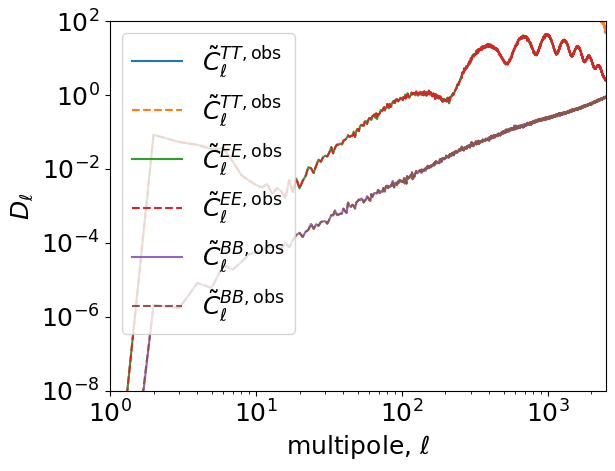

In [4]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(Tobs_fromspin0, lmax=lmax), label=r'$\tilde{C}_\ell^{TT, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(Tobs_fromspin2, lmax=lmax), label=r'$\tilde{C}_\ell^{TT, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin2[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 3: Ulensed alms, and philm ::: (e.g. N32)
Imagine you are given unlensed alms, philms, and noise levels of the experiment.

In this case, you will have to lens your data first, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [7]:
space = 'alm'
flavour = 'unl'
lmax = lmax
libdir = paths['unl']
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev = {'T': np.sqrt(2), 'P': np.sqrt(10)}
fns = {'T': 'T{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'E': 'E{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour), 'B': 'B{space}{flavour}_{{:05d}}.npy'.format(space=space, flavour=flavour)}

libdir_phi = paths['unl']
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=space)
phi_space = 'alm'
phi_field = 'potential'

dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        libdir = libdir,
        libdir_phi = libdir_phi,
        transfunction = transfunction,
        fns = fns,
        fnsP = fnsP,
        nlev = nlev,
        phi_field = phi_field,
        phi_space = phi_space,
        geominfo = geominfo,
))

INFO:: 06-14 14:28:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:28:08:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds


In [ ]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Text(0, 0.5, '$D_\\ell$')

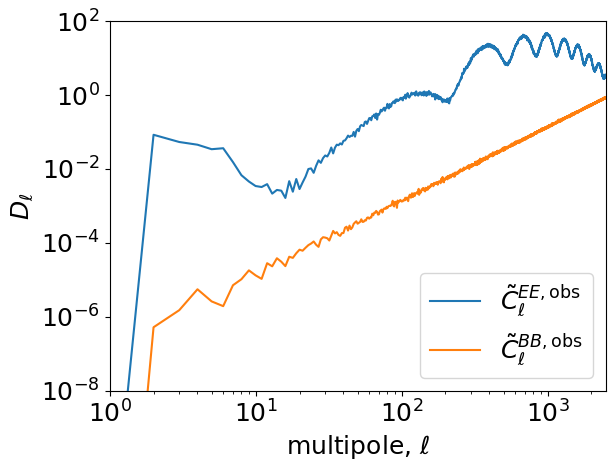

In [9]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 4 A: Cls and clphi ::: (e.g. N32)
Imagine you are given a CAMB-like file with CMB power spectra, and another file with the phi power spectrum, and noise levels of the experiment.

In this case, you will have to synthesize, then lens, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [10]:
space = 'cl'
flavour = 'unl'
lmax = lmax
clphi_fn = opj(os.path.dirname(delensalot.__file__), 'data', 'cls', 'FFP10_wdipole_lenspotentialCls.dat')
transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev = {'P': np.sqrt(10)/4}
phi_field = 'potential'

dm_spin0 = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        transfunction = transfunction,
        nlev = nlev,
        phi_field = phi_field,
        phi_fn = clphi_fn,
        geominfo = geominfo,
))

INFO:: 06-14 14:35:49:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:35:49:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds


In [ ]:
job_id = 'QE_lensrec'
jm0 = transform3d(dm_spin0, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0 = jm0.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Text(0, 0.5, '$D_\\ell$')

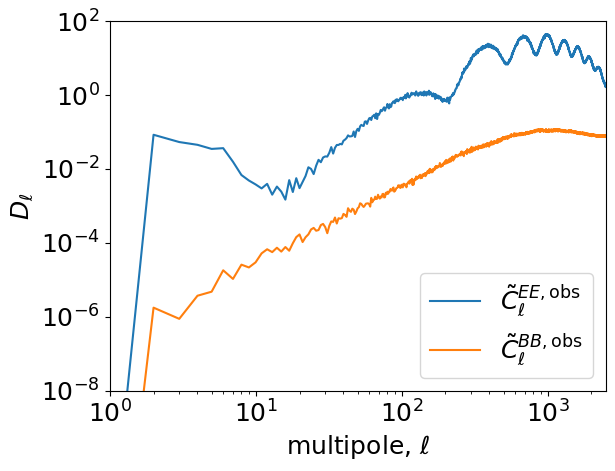

In [12]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

## Case 4 B: Cls and phi (alm or map) ::: (e.g. N32)
Imagine you are given a CAMB-like file with CMB power spectra, and another file with the phi realization, and noise levels of the experiment.

In this case, you will have to synthesize, then lens, then generate the observed data and noise.
No worries, `delensalot` has you covered, and thanks to `lenspyx`, it is also very fast!

All we need to do is configure a `DLENSALOT_Simulation` with the correct values.
 * unlensed alms
 * noise generator
 * phi alm
 * transfer function

In [2]:
space = 'cl'
flavour = 'unl'
lmax = lmax
phi_lmax = lmax + 1024
phi_space = 'alm'
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=phi_space)
phi_field = 'potential'
libdir_phi = paths['unl']

transfunction = gauss_beam(beam/180/60 * np.pi, lmax=lmax)
nlev = {'P': np.sqrt(10)/4}


dm_spin0_philm = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        transfunction = transfunction,
        nlev = nlev,
        phi_field = phi_field,
        phi_lmax = phi_lmax,
        libdir_phi = libdir_phi,
        fnsP = fnsP,
        phi_space = phi_space,
        geominfo = geominfo,
))

phi_space = 'map'
fnsP = 'phi{space}_{{:05d}}.npy'.format(space=phi_space)

dm_spin0_phimap = DLENSALOT_Model(
    simulationdata = DLENSALOT_Simulation(
        space = space, 
        flavour = flavour,
        lmax = lmax,
        transfunction = transfunction,
        nlev = nlev,
        phi_field = phi_field,
        phi_lmax = phi_lmax,
        libdir_phi = libdir_phi,
        fnsP = fnsP,
        phi_space = phi_space,
        geominfo = geominfo,
))

INFO:: 06-14 14:39:53:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:39:53:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds
INFO:: 06-14 14:39:53:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - analysis: couldnt find matching default value for reconstruction_method
INFO:: 06-14 14:39:53:: delensalot.config.metamodel.dlensalot_mm.__attrs_post_init__ - noisemodel: couldnt find matching default value for zbounds


In [ ]:
job_id = 'QE_lensrec'
jm0_philm = transform3d(dm_spin0_philm, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0philm = jm0_philm.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

jm0_phimap = transform3d(dm_spin0_phimap, job_id, l2delensalotjob_Transformer())
EBobs_fromspin0phimap = jm0_phimap.simulationdata.get_sim_obs(0, spin=0, space='map', field='polarization')

clear_output(wait=True)
print("Cell finished {}".format(datetime.now().strftime("%H:%M:%S")))

Text(0, 0.5, '$D_\\ell$')

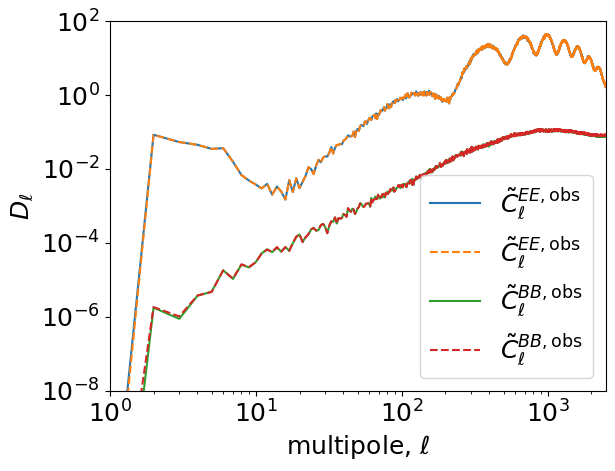

In [4]:
ll = np.arange(0,lmax+1,1)
scale_factor_l = (ll*(ll+1))/(2*np.pi)

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0philm[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0phimap[0], lmax=lmax), label=r'$\tilde{C}_\ell^{EE, \rm{obs}}$', ls='--')

plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0philm[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$')
plt.plot(scale_factor_l * hp.anafast(EBobs_fromspin0phimap[1], lmax=lmax), label=r'$\tilde{C}_\ell^{BB, \rm{obs}}$', ls='--')

plt.legend()
plt.xlim(1,lmax)
plt.ylim(1e-8,1e2)

plt.loglog()
plt.xlabel(r'multipole, $\ell$')
plt.ylabel(r'$D_\ell$')

This concludes the tutorial. If you'd like to see how to delens the data you have, go check out [this notebook](https://github.com/NextGenCMB/delensalot/blob/main/notebooks/examples/interactive_mwe.py).

# Summary and next steps
This tutorial demonstrated how to generate lensed simulation data.

To learn how to use `delensalot` for lensing reconstruction and more, check out the other tutorials, or see the [documentation](link_to_rtd_doc), or [github](https://github.com/NextGenCMB/delensalot).